In [1]:
from openai import OpenAI
import json
import re
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from IPython.display import display, Markdown
from copy import deepcopy
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset
from utils import *
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
%matplotlib inline

In [ ]:
client = OpenAI()

# Step 1: Explore the data

Explore the data in full

## 1. Metdata csv file

In [ ]:
df_call_metadata = pd.read_csv('/root/Prodigal-Take-Home/sentiment-take-home/sentiment-take-home/call_metadata.csv')
print(df_call_metadata.head())
print(df_call_metadata.info())

In [ ]:
print(df_call_metadata['type'].value_counts())

In [ ]:
print(df_call_metadata['disposition'].value_counts())

In [ ]:
df_call_metadata['disposition'] = df_call_metadata['disposition'].replace("No Pay - Can't pay now", "No Pay - Cant pay now")

In [ ]:
disposition_type_counts = df_call_metadata.groupby('disposition')['type'].value_counts().unstack(fill_value=0)
print(disposition_type_counts)

In [ ]:
positive_dispositions = set(disposition_type_counts[disposition_type_counts['positive'] > 0].index.tolist())
negative_dispositions = set(disposition_type_counts[disposition_type_counts['negative'] > 0].index.tolist())

print("Positive disposition types:", positive_dispositions)
print("Negative disposition types:", negative_dispositions)

In [ ]:
len(positive_dispositions), len(negative_dispositions)

### Split dataset into train-val-test

We do 80-10-10 train-val-test split, ensuring there is no class imbalance in either split

In [ ]:
from sklearn.model_selection import train_test_split

# Separate positive and negative samples
df_positive = df_call_metadata[df_call_metadata['type'] == 'positive']
df_negative = df_call_metadata[df_call_metadata['type'] == 'negative']

# Calculate split sizes
train_size = 0.8
val_size = 0.1
test_size = 0.1

def split_df(df, train_size, val_size, test_size):
    df_train, df_temp = train_test_split(df, train_size=train_size, random_state=42, shuffle=True)
    relative_val_size = val_size / (val_size + test_size)
    df_val, df_test = train_test_split(df_temp, train_size=relative_val_size, random_state=42, shuffle=True)
    return df_train, df_val, df_test

# Split positive and negative samples
pos_train, pos_val, pos_test = split_df(df_positive, train_size, val_size, test_size)
neg_train, neg_val, neg_test = split_df(df_negative, train_size, val_size, test_size)

# Concatenate to get final splits with equal positive and negative samples
train_df = pd.concat([pos_train, neg_train]).sample(frac=1, random_state=42).reset_index(drop=True)
val_df = pd.concat([pos_val, neg_val]).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat([pos_test, neg_test]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Train shape: {train_df.shape}, Positive: {(train_df['type'] == 'positive').sum()}, Negative: {(train_df['type'] == 'negative').sum()}")
print(f"Val shape: {val_df.shape}, Positive: {(val_df['type'] == 'positive').sum()}, Negative: {(val_df['type'] == 'negative').sum()}")
print(f"Test shape: {test_df.shape}, Positive: {(test_df['type'] == 'positive').sum()}, Negative: {(test_df['type'] == 'negative').sum()}")

In [ ]:
train_df.info()

In [ ]:
train_df.to_csv('/root/Prodigal-Take-Home/sentiment-take-home/sentiment-take-home/train_df.csv', index=False)
val_df.to_csv('/root/Prodigal-Take-Home/sentiment-take-home/sentiment-take-home/val_df.csv', index=False)
test_df.to_csv('/root/Prodigal-Take-Home/sentiment-take-home/sentiment-take-home/test_df.csv', index=False)

## 2. Conversations

In [ ]:
import os

conversation_folder = '/Users/sohammistri/Documents/Prodigal-Take-Home/sentiment-take-home/conversations'
txt_files = [f for f in os.listdir(conversation_folder) if f.endswith('.txt')]
print(f"Number of text files: {len(txt_files)}")

In [ ]:
# Remove '.txt' extension from txt_files to get basenames
txt_basenames = set([os.path.splitext(f)[0] for f in txt_files])

# Get set of _id values from df_call_metadata
df_ids = set(df_call_metadata['_id'])

assert txt_basenames == df_ids

In [ ]:
assert df_call_metadata['_id'].is_unique, "Not all _id values are unique in df_call_metadata"

In [ ]:
random_txt = random.choice(txt_files)
txt_path = os.path.join(conversation_folder, random_txt)
with open(txt_path, 'r') as f:
    content = f.read()

display(Markdown(f"### {random_txt}\n\n{content}"))

# Step 2: Identify Potential PII

For each conversation, flag potential PII in the call logs. Mostly looked clean, but imp to do a sanity check on a sample

In [ ]:
pii_filter_prompt = """
# Context:
"You are an AI assistant tasked with identifying and flagging customer Personally Identifiable Information (PII) within a given text. Your role is to act as a data protection filter.

You will be given a conversation between an AI agent and a customer as input. Here is how you should operate:
1.  Analyze the following conversation content provided between an AI agent and a customer.
2.  Your primary objective is to determine if any customer PII is present in the text. PII includes, but is not limited to:
    *   Names (full names, first names, last names)
    *   Email addresses
    *   Phone numbers
    *   Physical addresses (street, city, state, zip code)
    *   Social Security numbers or other government-issued identification numbers
    *   Credit card numbers or financial account information
    *   Dates of birth
    *   Login credentials (usernames, passwords)
    *   Medical information
    *   IP addresses or other unique device identifiers
3. Crucially, you must **ignore any data that has been masked**. Masked data is information that has been partially or fully obscured. Common examples of masking techniques to ignore include:
    - Redaction/Masking Out: Replacing parts of the data with characters like 'X', '*', or '#'. For instance, XXX-XX-1234 or john.doe@******.com.
    - Substitution/Replacement: Replacing sensitive data with fictitious yet realistic-looking data. For example, a real name might be replaced with a randomly generated one.
    - Tokenization/Encryption: Replacing data with a non-sensitive placeholder or an encrypted string.
    - Nulling Out: Replacing sensitive information with null values or blanks.
4. **Ignore Agent Names**: You must differentiate between the agent and the customer and ignore the agent's name. The agent's name may be stated explicitly (e.g., "My name is Alex," "This is SupportBot," or "You're speaking with Sarah."). Your focus is exclusively on identifying the **customer's PII**.
5.  After your analysis, you will provide a binary output:
    *   Return **1** if you identify any potential PII in the conversation that is unmasked.
    *   Return **0** if you do not find any PII in the conversation or **all** potential PII is masked out

# Output Format:
- Analysis of the conversation: <Detailed analysis of the conversation between the AI agent and customer wrt finding potential PII>
- Identified PII: <List of potential customer PII data identified in the conversation. Return None if the input is customer PII free>
- Score: <0 if there is no customer PII in the conversation or all customer PII is masked, 1 otherwise>

IMPORTANT: Remember to always adhere to this output format for consistency

# Input
Input Content: {conv} 

# Output
"""

In [ ]:
p = deepcopy(pii_filter_prompt)
random_txt = random.choice(txt_files)
txt_path = os.path.join(conversation_folder, random_txt)
txt_path = '/Users/sohammistri/Documents/Prodigal-Take-Home/sentiment-take-home/conversations/f8832c53-8b6c-4f73-bcce-b06c4f89b0f3.txt'
with open(txt_path, 'r') as f:
    content = f.read()

p = p.format(conv=content)
response = client.responses.create(
    model="gpt-4.1",
    input=p
)

display(Markdown(response.output_text))


In [ ]:
def extract_sections(text):
    analysis = None
    pii = None
    score = None

    analysis_match = re.search(r'- Analysis of the conversation:\s*(.*?)(?:- Identified PII:|$)', text, re.DOTALL)
    pii_match = re.search(r'- Identified PII:\s*(.*?)(?:- Score:|$)', text, re.DOTALL)
    score_match = re.search(r'- Score:\s*(\d+)', text)

    if analysis_match:
        analysis = analysis_match.group(1).strip()
    if pii_match:
        pii = pii_match.group(1).strip()
    if score_match:
        score = int(score_match.group(1).strip())

    return analysis, pii, score

def get_pii_score(prompt, file_path):
    with open(file_path, 'r') as f:
        content = f.read()

    try:
        p = deepcopy(prompt)
        p = p.format(conv=content)
        response = client.responses.create(
            model="gpt-4.1",
            input=p
        )
        response_out = response.output_text
        analysis, pii, score = extract_sections(response_out)
        result = {
            "file": file_path,
            "analysis": analysis,
            "pii": pii,
            "score": score
        }
        return result
    except Exception as e:
        print(e)
        return None

In [ ]:
txt_paths = [os.path.join(conversation_folder, fname) for fname in txt_files]
len(txt_paths)

In [ ]:
results = []

with ThreadPoolExecutor(max_workers=10) as executor:
    futures = [executor.submit(get_pii_score, pii_filter_prompt, file_path) for file_path in txt_paths]
    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing Files"):
        results.append(future.result())

In [ ]:
results_fil = [res for res in results if res is not None]
results_df = pd.DataFrame(results_fil)

In [ ]:
print(results_df['score'].value_counts())

In [ ]:
i = random.randint(0, len(results_df[results_df['score'] == 1]))
i

In [ ]:
display(Markdown(results_df[results_df['score'] == 1].iloc[i]["pii"]))

## Conclusion:
- Most of the PII is masked in this conversation
- Some PII is missed is mostly single names, diseases or when emails/phone no.s are spelled out. eg: "our seven dash zero zero dash two seven one nine dash three one nine two zero" spelled out
- Rule based PII failed but stronger LLM based filtering was able to catch it.

# 3. Get Zero Shot Prompting Results

Lets prompt some basic OpenAI LLMs and get the scores of agent and borrower sentiment

In [ ]:
sentiment_zero_shot_prompt = """
# INSTRUCTIONS:

You are an expert in sentiment analysis. Your task is to analyze the following conversation between an "Agent" (AI) and a "Borrower" (human). After your analysis, you will provide two outputs: one for the Agent Disposition and one for the Borrower Sentiment. 

The agent disposition refers to the call outcomes and **should** come from the following list:
  - **Positive disposition types**: ['Payment Plan Modification', 'Promise - Settlement in payments', 'Promise - Payment plan', 'Promise - One time payment', 'Promise - Settlement in full', 'Promise - Payment in full']
  - **Negative disposition types**: ['No Pay - Dispute', 'No Pay - Not right now', 'No Pay - Cancel payment plan', 'No Pay - Cant pay now', 'No Pay - Bankruptcy']

The borrower sentiment scores should be on a scale from 0 to 1, where **0 represents the most negative sentiment** and **1 represents the most positive sentiment**. 

**Follow these steps for your analysis:** 

1.  **Read the entire conversation carefully** to understand the context and the emotional tone of both the Agent and the Borrower. 
2.  **Identify key phrases and sentences** that indicate the sentiment of each participant. Consider the choice of words, the tone, and any emotional cues. 
3.  **Analyze the outcome** of the conversation. Determine whether the call achieved its objective — for example, was the borrower successfully contacted, did they agree to the repayment terms, was a promise to pay made, or did the agent resolve the borrower’s query? Assess the borrower's tone, cooperation level, and any commitments made. If there was no resolution, note the reason (e.g., borrower was unavailable, refused, or needed more time).
4.  **Analyze the sentiment of the Borrower** throughout the conversation. Note any expressions of frustration, satisfaction, confusion, or gratitude. 
5.  **Determine an overall outcome score for the call** based on your analysis. This should come from the list of possible outcomes provided to you above.
6.  **Determine an overall sentiment score for the Borrower** based on your analysis. This score should reflect the Borrower's dominant sentiment throughout the entire interaction. 
7.  **Provide a brief justification** for each score, referencing specific parts of the conversation.  

# Output Format:
Provide your analysis in the following JSON format. Do not include any text or explanations outside of the JSON structure.
```
{ 
  "conversation_analysis": { 
    "agent_sentiment": { 
      "analysis": <detailed analysis of the input conversation to help determine a call outcome>
      "disposition": <overall call outcome on the basis of the conversation as inferred by the agent>, 
    }, 
    "borrower_sentiment": { 
      "analysis": <detailed analysis of the borrower sentiment based on the input conversation to help determine a sentiment score>
      "score": <a score between 0-1 indicating the borrower sentiment, 0 being the most negative and 1 being the most positive>,
    } 
  } 
} 
```

**IMPORTANT**: Follow this output format strictly without extra formatting to ensure consistency

# Input:
Conversation: @conv@
"""

In [ ]:
def get_sentiment_scores(prompt, file_path):
    try:
        id = os.path.basename(file_path).split(".")[0]
        ext = os.path.basename(file_path).split(".")[-1]

        if ext == "txt":
            with open(file_path, "r") as f:
                content = f.read()
        elif ext =="json":
            with open(file_path, 'r') as f:
                content = json.load(f)
                content = str(content)
            
        p = deepcopy(prompt)
        p = p.replace("@conv@", content)
        response = client.responses.create(
            model="gpt-4.1",
            input=p
        )
        response_out = response.output_text

        # display(Markdown(response_out))

        result = json.loads(response_out.strip("```").strip("json"))

        return_val = {
            "_id": id,
            "agent_analysis": result["conversation_analysis"]["agent_sentiment"]["analysis"],
            "agent_score": result["conversation_analysis"]["agent_sentiment"]["disposition"],
            "borrower_analysis": result["conversation_analysis"]["borrower_sentiment"]["analysis"],
            "borrower_score": float(result["conversation_analysis"]["borrower_sentiment"]["score"]),
        }
        return return_val
    
    except Exception as e:
        print(e)
        return None

In [ ]:
txt_paths = [os.path.join(conversation_folder, fname) for fname in txt_files]

In [ ]:
results_txt = []

with ThreadPoolExecutor(max_workers=10) as executor:
    futures = [executor.submit(get_sentiment_scores, sentiment_zero_shot_prompt, file_path) for file_path in txt_paths]
    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing Files"):
        results_txt.append(future.result())

In [ ]:
results_txt_fil = [res for res in results_txt if res is not None]
results_txt_df = pd.DataFrame(results_txt_fil)
results_txt_df.info()

In [ ]:
results_txt_df.to_csv('/Users/sohammistri/Documents/Prodigal-Take-Home/sentiment-take-home/gpt_41_txt_file_zero_shot.csv', index=False)

In [ ]:
merged_df = df_call_metadata.merge(results_txt_df, on="_id", how="inner")
merged_df.head()

In [ ]:
merged_df['ground_truth_sentiment'] = (merged_df['type'] == 'positive').astype(int)

## Agent Score Analysis

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Ensure both columns are strings for comparison
y_true_agent = merged_df['disposition'].astype(str)
y_pred_agent = merged_df['agent_score'].astype(str)

# Compute metrics
acc_agent = accuracy_score(y_true_agent, y_pred_agent)
prec_agent = precision_score(y_true_agent, y_pred_agent, average='weighted', zero_division=0)
rec_agent = recall_score(y_true_agent, y_pred_agent, average='weighted', zero_division=0)
f1_agent = f1_score(y_true_agent, y_pred_agent, average='weighted', zero_division=0)

print(f"Agent Disposition Prediction Stats:")
print(f"Accuracy: {acc_agent:.4f}")
print(f"Precision (weighted): {prec_agent:.4f}")
print(f"Recall (weighted): {rec_agent:.4f}")
print(f"F1 Score (weighted): {f1_agent:.4f}")
print("\nClassification Report:")
print(classification_report(y_true_agent, y_pred_agent, zero_division=0))

# Confusion matrix
cm_agent = confusion_matrix(y_true_agent, y_pred_agent, labels=sorted(y_true_agent.unique()))
plt.figure(figsize=(10, 8))
sns.heatmap(cm_agent, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y_true_agent.unique()),
            yticklabels=sorted(y_true_agent.unique()))
plt.xlabel('Predicted Disposition')
plt.ylabel('True Disposition')
plt.title('Confusion Matrix: Agent Disposition Prediction')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Borrower Score Analysis

In [ ]:
# Calculate correlation coefficients between ground_truth_sentiment and borrower_score
corr_borrower = merged_df['ground_truth_sentiment'].corr(merged_df['borrower_score'])

print(f"Correlation (ground_truth_sentiment, borrower_score): {corr_borrower:.4f}")

In [ ]:
# Group by 'type' and describe agent_score and borrower_score
stats = merged_df.groupby('type')[['borrower_score']].describe()
print(stats)

# Plot distributions
# Single histogram plot for borrower_score by type
plt.figure(figsize=(8, 5))
for sentiment_type in ['positive', 'negative']:
    subset = merged_df[merged_df['type'] == sentiment_type]['borrower_score']
    plt.hist(subset, bins=20, alpha=0.6, label=sentiment_type)
plt.title('Distribution of Borrower Score by Type')
plt.xlabel('Score')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

# Boxplots for visual comparison
plt.figure(figsize=(10, 5))
merged_df.boxplot(column=['borrower_score'], by='type')
plt.suptitle('')
plt.title('Borrower Score by Type')
plt.xlabel('Type')
plt.ylabel('Score')
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Prepare true labels and predicted scores from merged_df
y_true = merged_df['ground_truth_sentiment']
y_scores = merged_df['borrower_score']

# Compute ROC curve and ROC-AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = roc_auc_score(y_true, y_scores)

# Find optimal threshold (maximizing TPR - FPR)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal threshold = {optimal_threshold:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Borrower Sentiment Score')
plt.legend()
plt.show()

print(f"Optimal threshold: {optimal_threshold:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")

In [ ]:
from sklearn.metrics import confusion_matrix

# Use optimal_threshold from previous ROC analysis
pred_optimal = (merged_df['borrower_score'] >= optimal_threshold).astype(int)
true_labels = merged_df['ground_truth_sentiment']

acc = accuracy_score(true_labels, pred_optimal)
prec = precision_score(true_labels, pred_optimal, zero_division=0)
rec = recall_score(true_labels, pred_optimal, zero_division=0)
f1 = f1_score(true_labels, pred_optimal, zero_division=0)
cm = confusion_matrix(true_labels, pred_optimal)

print(f"Optimal threshold: {optimal_threshold:.2f}")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 4. Get metrics for the FT model

## Agent

In [2]:
checkpoint_path = "ckpts/modernbert-agent/checkpoint-1000/"

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint_path)

In [3]:
train_path = '/root/Prodigal-Take-Home/sentiment-take-home/sentiment-take-home/train_df.csv'
val_path = '/root/Prodigal-Take-Home/sentiment-take-home/sentiment-take-home/val_df.csv'
test_path = '/root/Prodigal-Take-Home/sentiment-take-home/sentiment-take-home/test_df.csv'

conversations_path = '/root/Prodigal-Take-Home/sentiment-take-home/sentiment-take-home/conversations'

train_df = create_dataset(train_path, conversations_path, label2id_agent, "disposition")
val_df = create_dataset(val_path, conversations_path, label2id_agent, "disposition")
test_df = create_dataset(test_path, conversations_path, label2id_agent, "disposition")


In [4]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)
    
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
val_df = val_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

train_dataset = Dataset.from_pandas(train_df).map(tokenize_function, batched=True).remove_columns(['text'])
val_dataset = Dataset.from_pandas(val_df).map(tokenize_function, batched=True).remove_columns(['text'])
test_dataset = Dataset.from_pandas(test_df).map(tokenize_function, batched=True).remove_columns(['text'])

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [5]:
model.config.num_labels

11

In [6]:
model.eval()

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ModernBertForSequenceClassification(
  (model): ModernBertModel(
    (embeddings): ModernBertEmbeddings(
      (tok_embeddings): Embedding(50368, 768, padding_idx=50283)
      (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (layers): ModuleList(
      (0): ModernBertEncoderLayer(
        (attn_norm): Identity()
        (attn): ModernBertAttention(
          (Wqkv): Linear(in_features=768, out_features=2304, bias=False)
          (rotary_emb): ModernBertRotaryEmbedding()
          (Wo): Linear(in_features=768, out_features=768, bias=False)
          (out_drop): Identity()
        )
        (mlp_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): ModernBertMLP(
          (Wi): Linear(in_features=768, out_features=2304, bias=False)
          (act): GELUActivation()
          (drop): Dropout(p=0.0, inplace=False)
          (Wo): Linear(in_features=1152, out_features=768, bias=False)
        )
      

100%|██████████| 4/4 [00:52<00:00, 13.10s/it]


📊 Classification Report for Validation:
              precision    recall  f1-score   support

           0     0.4857    0.7727    0.5965        22
           1     0.6000    0.6923    0.6429        13
           2     0.7857    0.6111    0.6875        18
           3     0.5758    0.5588    0.5672        34
           4     0.8864    0.9070    0.8966        43
           5     0.5500    0.6667    0.6027        33
           6     1.0000    0.8000    0.8889         5
           7     0.6667    0.5000    0.5714        12
           8     0.0000    0.0000    0.0000         9
           9     0.8000    0.3636    0.5000        11

    accuracy                         0.6550       200
   macro avg     0.6350    0.5872    0.5954       200
weighted avg     0.6513    0.6550    0.6419       200



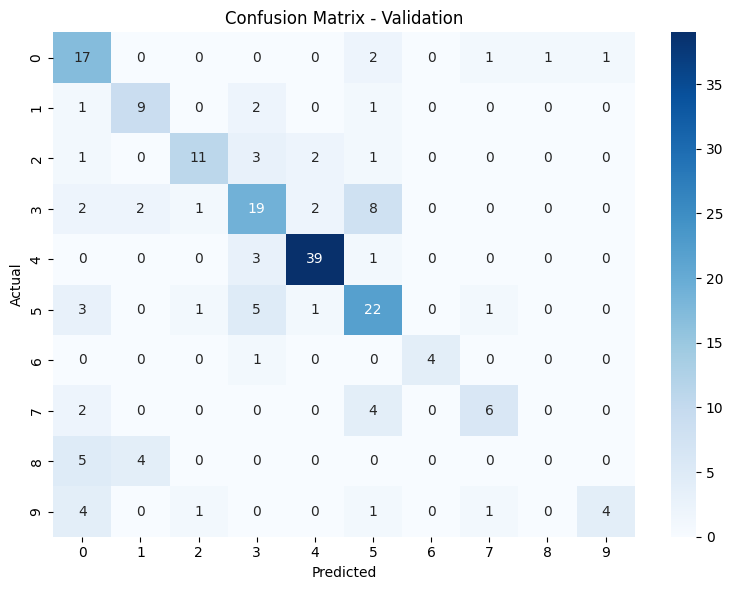

100%|██████████| 4/4 [00:51<00:00, 12.98s/it]


📊 Classification Report for Test:
              precision    recall  f1-score   support

           0     0.6207    0.7826    0.6923        23
           1     0.5714    0.7273    0.6400        11
           2     0.8400    0.7778    0.8077        27
           3     0.4800    0.5217    0.5000        23
           4     0.9167    0.9167    0.9167        48
           5     0.6667    0.7273    0.6957        33
           6     1.0000    1.0000    1.0000         1
           7     0.8333    0.4167    0.5556        12
           8     0.5000    0.1250    0.2000         8
           9     0.5714    0.6154    0.5926        13
          10     0.0000    0.0000    0.0000         1

    accuracy                         0.7100       200
   macro avg     0.6364    0.6009    0.6000       200
weighted avg     0.7136    0.7100    0.7010       200




/root/Prodigal-Take-Home/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/Prodigal-Take-Home/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/Prodigal-Take-Home/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", l

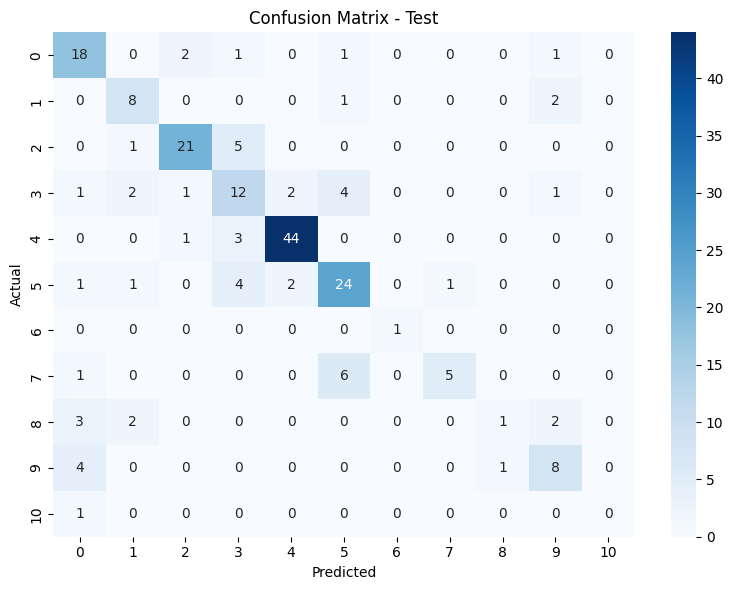

In [ ]:
# Inference function
def run_inference(dataset, name="dataset"):
    all_preds = []
    all_labels = []

    dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    loader = DataLoader(dataset, batch_size=64)

    for batch in tqdm(loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    print(f"\n📊 Classification Report for {name}:")
    print(classification_report(all_labels, all_preds, digits=4))

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    return all_labels, all_preds

# Run on all datasets
val_labels, val_preds = run_inference(val_dataset, "Validation")
test_labels, test_preds = run_inference(test_dataset, "Test")

100%|██████████| 25/25 [06:54<00:00, 16.60s/it]


📊 Classification Report for Train:
              precision    recall  f1-score   support

           0     0.7866    0.8910    0.8356       211
           1     0.8667    0.9353    0.8997       139
           2     0.9503    0.8547    0.9000       179
           3     0.8379    0.8870    0.8618       239
           4     0.9632    0.9770    0.9700       348
           5     0.8876    0.9595    0.9222       247
           6     0.9167    0.9167    0.9167        24
           7     0.9310    0.6750    0.7826        80
           8     0.7391    0.3696    0.4928        46
           9     0.8889    0.8312    0.8591        77
          10     0.0000    0.0000    0.0000        10

    accuracy                         0.8856      1600
   macro avg     0.7971    0.7543    0.7673      1600
weighted avg     0.8814    0.8856    0.8795      1600




/root/Prodigal-Take-Home/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/Prodigal-Take-Home/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/Prodigal-Take-Home/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", l

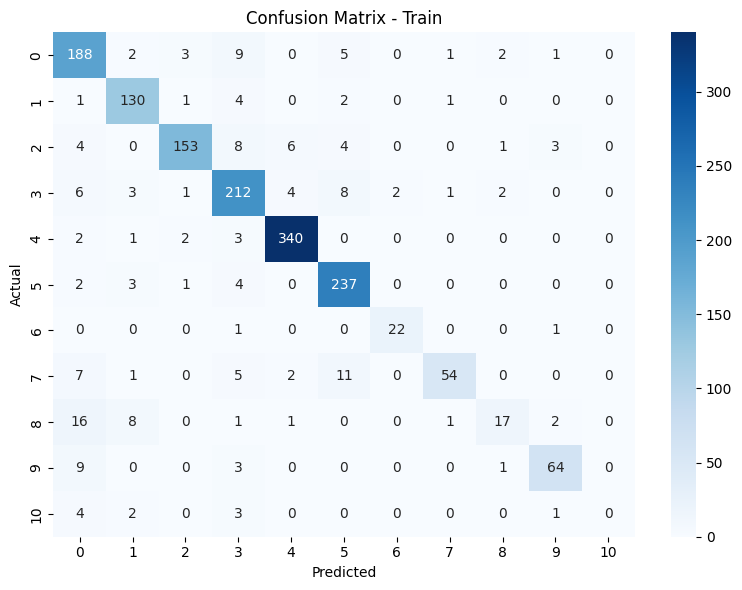

In [8]:
train_labels, train_preds = run_inference(train_dataset, "Train")

## Borrower

In [2]:
checkpoint_path = "ckpts/modernbert-borrower/checkpoint-800/"

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint_path)

In [5]:
train_path = '/root/Prodigal-Take-Home/sentiment-take-home/sentiment-take-home/train_df.csv'
val_path = '/root/Prodigal-Take-Home/sentiment-take-home/sentiment-take-home/val_df.csv'
test_path = '/root/Prodigal-Take-Home/sentiment-take-home/sentiment-take-home/test_df.csv'

conversations_path = '/root/Prodigal-Take-Home/sentiment-take-home/sentiment-take-home/conversations'

train_df = create_dataset(train_path, conversations_path, label2id_borrower, "type")
val_df = create_dataset(val_path, conversations_path, label2id_borrower, "type")
test_df = create_dataset(test_path, conversations_path, label2id_borrower, "type")


In [6]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)
    
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
val_df = val_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

train_dataset = Dataset.from_pandas(train_df).map(tokenize_function, batched=True).remove_columns(['text'])
val_dataset = Dataset.from_pandas(val_df).map(tokenize_function, batched=True).remove_columns(['text'])
test_dataset = Dataset.from_pandas(test_df).map(tokenize_function, batched=True).remove_columns(['text'])

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [7]:
model.config.num_labels

2

In [8]:
model.eval()

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ModernBertForSequenceClassification(
  (model): ModernBertModel(
    (embeddings): ModernBertEmbeddings(
      (tok_embeddings): Embedding(50368, 768, padding_idx=50283)
      (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (layers): ModuleList(
      (0): ModernBertEncoderLayer(
        (attn_norm): Identity()
        (attn): ModernBertAttention(
          (Wqkv): Linear(in_features=768, out_features=2304, bias=False)
          (rotary_emb): ModernBertRotaryEmbedding()
          (Wo): Linear(in_features=768, out_features=768, bias=False)
          (out_drop): Identity()
        )
        (mlp_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): ModernBertMLP(
          (Wi): Linear(in_features=768, out_features=2304, bias=False)
          (act): GELUActivation()
          (drop): Dropout(p=0.0, inplace=False)
          (Wo): Linear(in_features=1152, out_features=768, bias=False)
        )
      

100%|██████████| 4/4 [00:52<00:00, 13.19s/it]


📊 Classification Report for Validation:
              precision    recall  f1-score   support

           0     0.8641    0.8900    0.8768       100
           1     0.8866    0.8600    0.8731       100

    accuracy                         0.8750       200
   macro avg     0.8753    0.8750    0.8750       200
weighted avg     0.8753    0.8750    0.8750       200



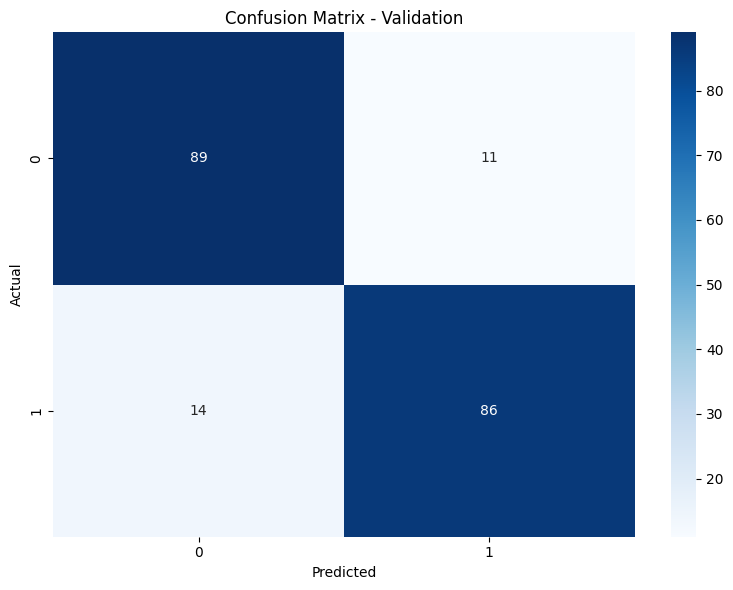

100%|██████████| 4/4 [00:51<00:00, 12.95s/it]


📊 Classification Report for Test:
              precision    recall  f1-score   support

           0     0.8922    0.9100    0.9010       100
           1     0.9082    0.8900    0.8990       100

    accuracy                         0.9000       200
   macro avg     0.9002    0.9000    0.9000       200
weighted avg     0.9002    0.9000    0.9000       200



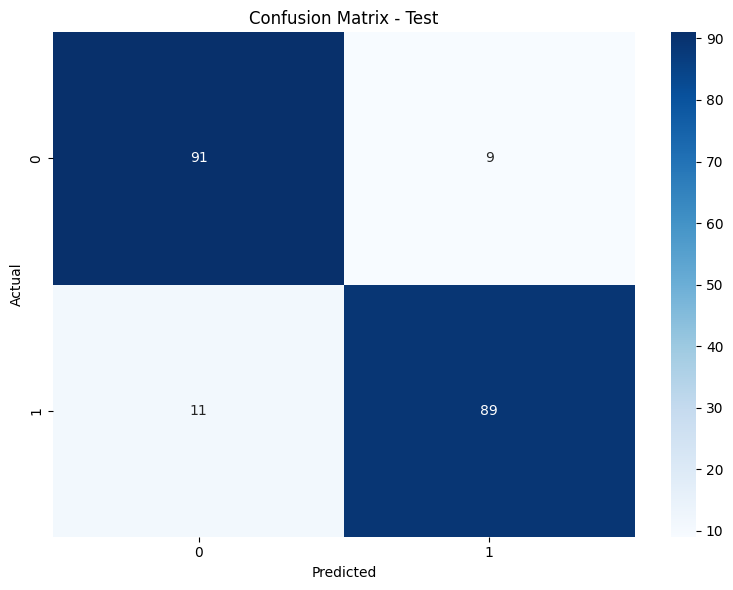

In [9]:
# Inference function
def run_inference(dataset, name="dataset"):
    all_preds = []
    all_labels = []

    dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    loader = DataLoader(dataset, batch_size=64)

    for batch in tqdm(loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    print(f"\n📊 Classification Report for {name}:")
    print(classification_report(all_labels, all_preds, digits=4))

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    return all_labels, all_preds

# Run on all datasets
val_labels, val_preds = run_inference(val_dataset, "Validation")
test_labels, test_preds = run_inference(test_dataset, "Test")

100%|██████████| 25/25 [06:53<00:00, 16.52s/it]


📊 Classification Report for Train:
              precision    recall  f1-score   support

           0     0.8996    0.9300    0.9146       800
           1     0.9276    0.8962    0.9116       800

    accuracy                         0.9131      1600
   macro avg     0.9136    0.9131    0.9131      1600
weighted avg     0.9136    0.9131    0.9131      1600



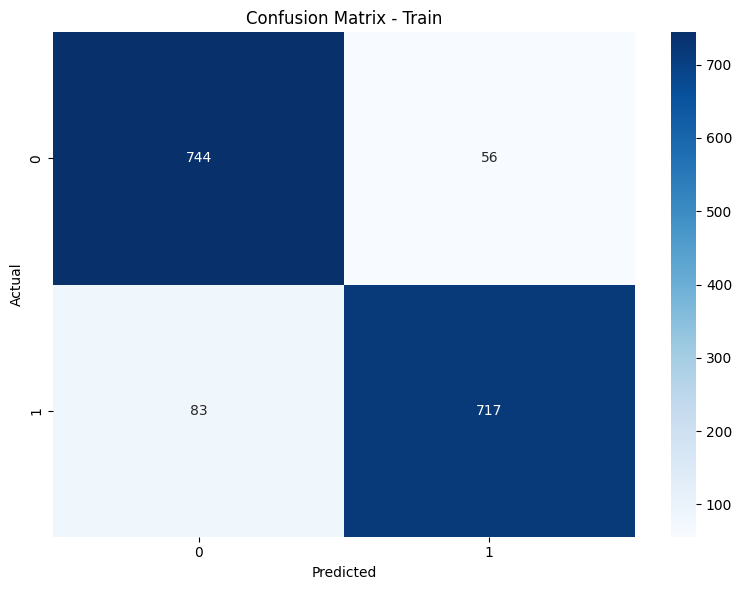

In [10]:
train_labels, train_preds = run_inference(train_dataset, "Train")